In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial, signal
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
from IPython.display import display, HTML
import pandas as pd
import pickle
import re
from scanf import scanf

import matplotlib
# matplotlib.use('agg')
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm
from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb

# %matplotlib notebook
%matplotlib inline
rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

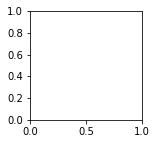

In [2]:
fig = plt.figure(figsize=(2, 2))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)

In [3]:
def get_major_fre(*arg, **kwargs):
    return spf_tb.get_major_fre(*arg, **kwargs)
    
def load_rand_data_pickle_dir_v3(t_dir, t_headle='(.*?).pickle', n_load=None, rand_mode=False, 
                                 add_info=False): 
    t_path = os.listdir(t_dir)
    filename_list = [filename for filename in t_path if re.match(t_headle, filename) is not None]
    wt_list = []
    pickle_path_list = []
    mean_eta_list = []
    std_psi_list = []
    dx_list = []
    dy_list = []
    dz_list = []
    dpsi_list = []
    
    n_load = len(filename_list) if n_load is None else n_load
    assert n_load <= len(filename_list)
    if rand_mode:
        tidx = np.random.choice(len(filename_list), n_load, replace=False)
    else:
        tidx = np.arange(n_load)
    use_filename_list = np.array(filename_list)[tidx]

    for tname in use_filename_list:
        tpath = os.path.join(t_dir, tname)
        with open(tpath, 'rb') as handle:
                tpick = pickle.load(handle)
        wt_list.append(tpick['omega_tail'])
        pickle_path_list.append(tpath)

        # fft rule
        tx = tpick['Table_t']
        tmin = np.max((0, tx.max() - 1000))
        idx = tx > tmin
        freq_pk = get_major_fre(tx[idx], tpick['Table_theta'][idx])
        idx = tx > (tx.max() - 1 / freq_pk * 10)
        mean_eta_list.append(np.mean(tpick['Table_eta'][idx]))
        std_psi_list.append((np.mean(tpick['Table_psi'][idx]), np.std(tpick['Table_psi'][idx])))
        for i0, tlist in enumerate((dx_list, dy_list, dz_list)):
            tpoly = np.polyfit(tx[idx], tpick['Table_X'][idx, i0], 1, w=np.blackman(idx.sum()))
            tlist.append(tpoly[0])
        dpsi_list.append(np.polyfit(tx[idx], spf_tb.get_increase_angle(tpick['Table_psi'][idx]), 
                                    deg=1, w=np.blackman(idx.sum()))[0])

    wt_list = np.hstack(wt_list)
    pickle_path_list = np.array(pickle_path_list)
    mean_eta_list = np.hstack(mean_eta_list)
    std_psi_list = np.array(std_psi_list)
    dx_list = np.hstack(dx_list)
    dy_list = np.hstack(dy_list)
    dz_list = np.hstack(dz_list)
    dpsi_list = np.hstack(dpsi_list)
    if add_info:
        return dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, \
                (std_psi_list, dpsi_list)
    else: 
        return dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list


In [4]:
n_load = None
rand_mode=False
job_dir_list = ['ecoC01B05_inithphps_f', ]
t_headle = '(.*?).pickle'
data_list = []

for job_dir in job_dir_list:
    use_dir = os.path.join(os.getcwd(), job_dir)
    dir_list = [o for o in os.listdir(use_dir) if (os.path.isdir(os.path.join(use_dir, o)) 
                                                   and not o.startswith('.'))]
    print(use_dir)
    for sub_dir in tqdm_notebook(dir_list[:]):
        t_dir = os.path.join(use_dir, sub_dir)
        data_list.append(load_rand_data_pickle_dir_v3(t_dir, t_headle, n_load=n_load, 
                                                      rand_mode=rand_mode))
    # data_list = np.array(data_list)

FileNotFoundError: [Errno 2] No such file or directory: '/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_f'

In [ ]:
# %matplotlib notebook
%matplotlib inline

figsize = np.array((16, 9)) * 0.2
dpi = 1000 if 'inline' in matplotlib.get_backend() else 100
linthreshx = 1e-3
linscalex = 0.5

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')

wt_all = []
dy_all = []
for _ in data_list[:]:
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, = _
    tidx = np.argsort(wt_list)
    axi.plot(wt_list[tidx], dy_list[tidx], '.C0', alpha=0.01)
    wt_all.append(wt_list)
    dy_all.append(dy_list)
wt_all = np.hstack(wt_all)
tidx = np.argsort(wt_all)
wt_all = wt_all[tidx]
dy_list = np.hstack(dy_all)[tidx]
spf.fit_line(axi, wt_all, dy_list, 20, np.inf, extendline=True, color='k', alpha=1)
axi.patch.set_alpha(0)
# axi.set_xlabel('$\\omega_t / \\tau_s$')
# axi.set_ylabel('$u_2$')
axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
# axi.axvspan(0, 0.015, alpha=0.05, color='gray')
# axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
# axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
print(axi.get_xlim(), axi.get_ylim())
# plt.tight_layout()